In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import annotations
import numpy as np

from matplotlib import rc, colors, ticker
import matplotlib.pyplot as plt

from sunpy.net import Fido, attrs as a
import astropy.units as u
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astropy.coordinates import SkyCoord
import sunpy.map
from matplotlib.patches import ConnectionPatch
from matplotlib import colors

from mhsflex.field2d import Field2dData, check_fluxbalance, alpha_HS04
from mhsflex.field3d import Field3dData, calculate_magfield

from mhsflex.vis import plot

rc("font", **{"family": "serif", "serif": ["Times"]})
rc("text", usetex=True)

c4 = (1.000, 0.224, 0.376)
c1 = (0.439, 0.788, 1.000)
c3 = "black"
c2 = (0.420, 0.502, 1.000)

cmap = colors.LinearSegmentedColormap.from_list(
    "cmap",
    (
        (0.000, (0.000, 0.000, 0.000)),
        (0.500, (0.659, 0.659, 0.659)),
        (1.000, (1.000, 1.000, 1.000)),
    ),
)

cmap2 = colors.LinearSegmentedColormap.from_list(
    "cmap2", ((0.000, (0.984, 1.000, 0.000)), (1.000, (1.000, 0.988, 0.761)))
)

c2 = (0.420, 0.502, 1.000)
c3 = "black"
c4 = (1.000, 0.224, 0.376)
c5 = (0.784, 0.231, 0.576)
c7 = (0.992, 0.251, 0.733)
c8 = (0.867, 0.871, 0.184)
c9 = (0.949, 0.922, 0.678)
c10 = (0.984, 0.455, 0.231)
c11 = (0.765, 0.835, 0.922)
c12 = (0.965, 0.694, 0.486)
c13 = (0.992, 0.584, 0.820)

/Users/lilli/Library/Caches/pypoetry/virtualenvs/mflex-cNoQEf_u-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = "/Users/lilli/Desktop/SOAR/obs/solo_L2_phi-hrt-blos_20220307T000609_V01.fits"
# path="/Users/lilli/Desktop/Thesis/soneu/solo_L2_phi-hrt-blos_20230329T125009_V01.fits"
data2d = Field2dData.from_fits_SolOr(path)

z0 = 2.0
deltaz = 0.2
b = 1.0

ValueError: invalid literal for int() with base 10: ''

In [41]:
print(data2d.bz.max())
print(data2d.bz.min())

1594.516
-2252.8496


In [42]:
x_grid, y_grid = np.meshgrid(data2d.x, data2d.y)
norm = colors.SymLogNorm(50, vmin=-7.5e2, vmax=7.5e2)

In [43]:
print(data2d.ny)

2048


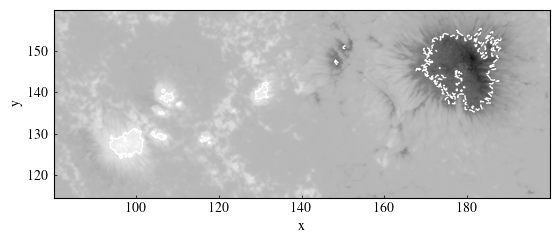

In [67]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(x_grid[630:880,440:1100], y_grid[630:880,440:1100], data2d.bz[630:880,440:1100], 1000, cmap=cmap) #, norm=norm)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect((880-630)/(1100-440))
plt.tick_params(direction="in", length=2, width=0.5)

CS = ax.contour(
    x_grid[630:880,440:1100], y_grid[630:880,440:1100], data2d.bz[630:880,440:1100],
    levels=(-1000, 1000),
    colors="white",
    linewidths=1.0,
)
plt.show()

In [68]:
data2d = Field2dData.from_fits_SolOr(path)

In [70]:
x_grid, y_grid = np.meshgrid(data2d.x, data2d.y)

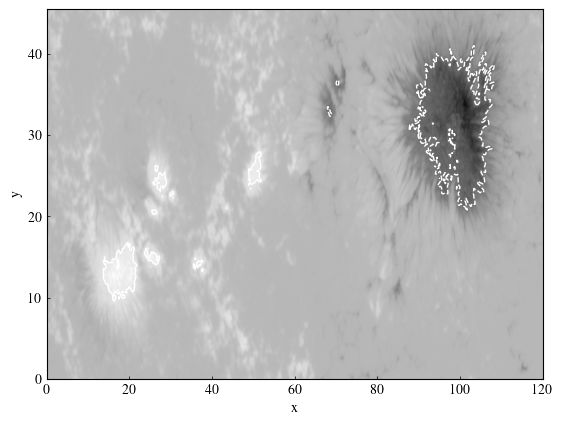

In [71]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(x_grid, y_grid, data2d.bz, 1000, cmap=cmap) #, norm=norm)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.tick_params(direction="in", length=2, width=0.5)

CS = ax.contour(
    x_grid, y_grid, data2d.bz,
    levels=(-1000, 1000),
    colors="white",
    linewidths=1.0,
)
plt.show()

In [46]:
print(data2d.nx, data2d.ny)
print(data2d.nx * data2d.px)

2048 2048
372.36517391475746


In [66]:
160 / data2d.py

879.9963663492686

In [72]:
check_fluxbalance(data2d)

-0.119143665

In [75]:
alpha = 0.025

length_scale = float(2.0)  # Normalising length scale for Seehafer

length_scale_x = 2.0 * data2d.nx * data2d.px
length_scale_y = 2.0 * data2d.ny * data2d.py

length_scale_x_norm = length_scale_x / length_scale 
length_scale_y_norm = length_scale_y / length_scale 

kx_arr = np.arange(data2d.nf) * np.pi / length_scale_x_norm  # [0:nf_max]
ky_arr = np.arange(data2d.nf) * np.pi / length_scale_y_norm  # [0:nf_max]
one_arr = 0.0 * np.arange(data2d.nf) + 1.0

ky_grid = np.outer(ky_arr, one_arr)  # [0:nf_max, 0:nf_max]
kx_grid = np.outer(one_arr, kx_arr)  # [0:nf_max, 0:nf_max]

# kx^2 + ky^2

k2_arr = np.outer(ky_arr**2, one_arr) + np.outer(one_arr, kx_arr**2)
k2_arr[0, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2
k2_arr[1, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2
k2_arr[0, 1] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2

# Need k^2 > alpha^2/(1-2a) and k^2 > alpha^2

limit = 1 / 2 * (1 - alpha**2 / k2_arr)

print(limit.min())

0.38601272706354595


In [76]:
data3d = calculate_magfield(data2d, 0.38, 1.0, 0.025, 2.0, 0.2)

In [77]:
path2save = "/Users/lilli/Desktop/Thesis/soneu/data"
data3d.save(path2save)

In [4]:
data3d = Field3dData.load("/Users/lilli/Desktop/Thesis/soneu/data")

In [5]:
folder="/Users/lilli/Desktop/Thesis/soneu"

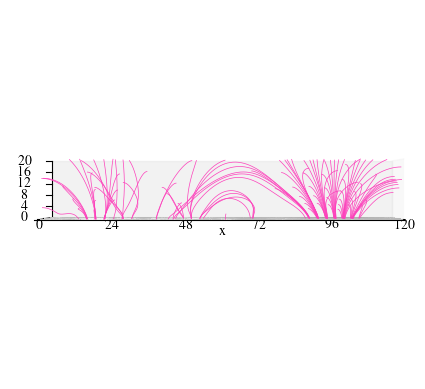

In [6]:
plot(data3d, view="side", save=True, path=folder)

In [7]:
dp_max = np.zeros_like(data3d.z)
dp_min = np.zeros_like(data3d.z)

dd_max = np.zeros_like(data3d.z)
dd_min = np.zeros_like(data3d.z)

for iz in range(data3d.nz):
    dp_max[iz] = data3d.dpressure[:, :, iz].max()
    dp_min[iz] = data3d.dpressure[:, :, iz].min()
    dd_max[iz] = data3d.ddensity[:, :, iz].max()
    dd_min[iz] = data3d.ddensity[:, :, iz].min()

/var/folders/cr/r56x0z910tncp30pdz4343cm0000gn/T/ipykernel_1561/3429109627.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False, fontsize=12)


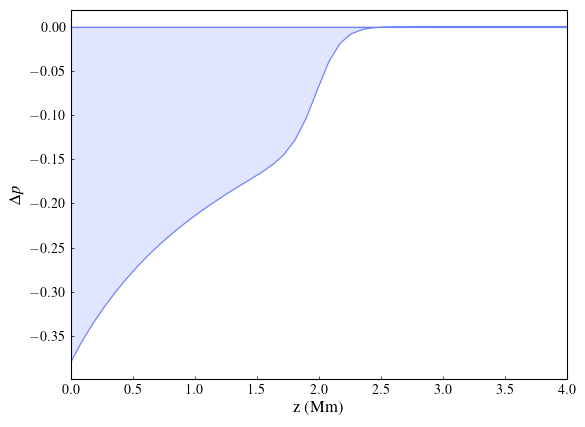

In [12]:
fig, ax1 = plt.subplots()
ax1.fill_between(data3d.z, dp_min, dp_max, color=c2, alpha=0.2)

ax1.plot(
    data3d.z,
    dp_max,
    linewidth=0.8,
    color= c2,
    # label=r"B-den, $\rho_0$ prescribed, linear",
)
ax1.plot(
    data3d.z,
    dp_min,
    linewidth=0.8,
    color= c2,
    # label=r"B-den, $p_0$ prescribed, linear",
)


ax1.set_ylabel(r"$\Delta p$", fontsize=12)
ax1.set_xlabel(r"z (Mm)", fontsize=12)
plt.legend(frameon=False, fontsize=12)
plt.tick_params(direction="in", length=2, width=0.5)
ax1.set_xlim(0, 4.0)
plotname = folder + "/dpres.png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

/var/folders/cr/r56x0z910tncp30pdz4343cm0000gn/T/ipykernel_1561/3766173928.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False, fontsize=12)


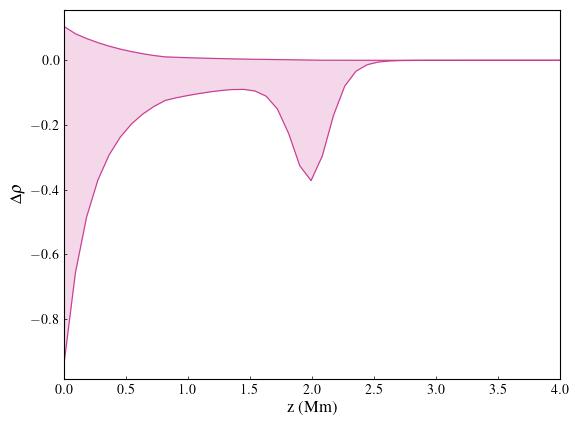

In [11]:
fig, ax1 = plt.subplots()
ax1.fill_between(data3d.z, dd_min, dd_max, color=c5, alpha=0.2)

ax1.plot(
    data3d.z,
    dd_max,
    linewidth=0.8,
    color= c5,
    # label=r"B-den, $\rho_0$ prescribed, linear",
)
ax1.plot(
    data3d.z,
    dd_min,
    linewidth=0.8,
    color= c5,
    # label=r"B-den, $p_0$ prescribed, linear",
)


ax1.set_ylabel(r"$\Delta \rho$", fontsize=12)
ax1.set_xlabel(r"z (Mm)", fontsize=12)
plt.legend(frameon=False, fontsize=12)
plt.tick_params(direction="in", length=2, width=0.5)
ax1.set_xlim(0, 4.0)
plotname = folder + "/dden.png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()